Analysis


In [94]:
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from sklearn.metrics import classification_report,confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from skimage import io
import seaborn as sns
import pandas as pd
import collections
import numpy as np
import scipy.stats
import statistics
import urllib
import json
import cv2
import os

class Biycle:
    """
    A class to do analysis on Bicycle data

    """
    def __init__(self, reference_file, project_file):
        """
        Parameters
        ----------
        reference_file : str
            json filepath for reference file
        project_file : str
            json filepath for project file
        annotators : dictionary object
            dict to save all the annotators data
        average_time: list
            list of all the time taken for each question
        """
        self.reference_data = self.json_to_dict(reference_file)
        self.project_data = self.json_to_dict(project_file)
        self.annotators = {}
        self.average_time = []
        
    def json_to_dict(self, json_file):
        """
        Json to dictionary converter function
        Parameters
        ----------
        json_file : str
            json filepath to convert into dict object
        Returns
        ----------
        dictionary object
        """
        dict_data = None
        with open(json_file) as jsonfile:
            dict_data = json.load(jsonfile)
        print(len(dict_data))
        return dict_data
    
    def annotator_object(self):
        """
        helper function to generate annotator object
        Returns
        ----------
        object to store annotator data
        """
        return {
            "Attempted": 0,
            "cant_solve": 0,
            "corrupt_data": 0,
            "duration": 0,
            "answered_correct": 0
            }
    
    def answer_detector(self, user_data):
        """
        Helper Function to return the truth value if imge is biycle or not
        Parameters
        ----------
        user_data : dict
            user_data fetched to return truthy value
        Returns
        ----------
        Int:
            1 if img is biycle 0 if not
        """
        reference_data = self.reference_data
        answer = "no"
        img_id = user_data["task_input"]["image_url"][-12:-4]
        if img_id in reference_data.keys():
            truthy_value = reference_data[img_id]
            if truthy_value["is_bicycle"] == "True":
                answer = "yes"
            if user_data["task_output"]["answer"] == answer:
                return 1
        return 0
    
    def annotator_object_counter(self, object_counter, user_data):
        """
        Helper Function to update annotator object fields
        ----------
        object_counter : dict
            annotator object to be updated
        user_data : dict
            user_data fetched to return truthy value
        Returns
        ----------
        dict:
            Updated Annotator Object
        """
        reference_data = self.reference_data
        object_counter["Attempted"] = object_counter["Attempted"] + 1
        if user_data["task_output"]["cant_solve"] == "True":
            object_counter["cant_solve"] = object_counter["cant_solve"] + 1
        if user_data["task_output"]["corrupt_data"] == "True":
            object_counter["corrupt_data"] = object_counter["corrupt_data"] + 1
        if user_data["task_output"]["duration_ms"]>0:
            object_counter["duration"] = object_counter["duration"] + user_data["task_output"]["duration_ms"]
        object_counter["answered_correct"] = object_counter["answered_correct"] + self.answer_detector(user_data)
        return object_counter
    
    def main_data_processing(self):
        """
        Main Function to execute the data filteration
        ----------
        Updates annotators global dictionary object and average time.
        """
        project_data = self.project_data
        annotators = {}
        average_time = self.average_time
        root_data = project_data["results"]["root_node"]["results"]
        for items in root_data:
            for last_child in root_data[items]["results"]:
                if last_child["task_output"]["duration_ms"]>0:
                    average_time.append(last_child["task_output"]["duration_ms"])
                annotator = last_child["user"]["vendor_user_id"]
                if annotator in annotators.keys():
                    annotators[annotator] = self.annotator_object_counter(annotators[annotator], last_child)
                else:
                    annotators[annotator]= self.annotator_object()
                    annotators[annotator] = self.annotator_object_counter(annotators[annotator], last_child)
        self.annotators = annotators
        self.average_time = average_time
        
    def update_annotators(self):
        """
        Update Annotators Function to update annotator data by including
        percentage correct and adjusted percentage fields
        ----------
        Updates annotators global dictionary object
        """
        annotators = self.annotators
        for keys, values in annotators.items():
            object_annotator = annotators[keys]
            object_annotator["duration"] = round(annotators[keys]["duration"]/annotators[keys]["Attempted"])
            percentage_correct_answers = round((object_annotator["answered_correct"]/object_annotator["Attempted"])*100)
            adjusted_percentage = round((object_annotator["answered_correct"]/9087)*100)
            object_annotator["percentage_correct"] = percentage_correct_answers
            object_annotator["adjusted_percentage"] = adjusted_percentage
            annotators[keys] = object_annotator
        annotators = collections.OrderedDict(sorted(annotators.items()))
        self.annotators = annotators
    def generate_annotators_graph_count(self):
        """
        Generates graph for all the annotators and their count of attemped questions
        """
        annotators = self.annotators
        keys = list(annotators.keys())
        values = [items["Attempted"] for items in annotators.values()]
        plt.xticks(rotation=45,ha='right')
        plt.title("Annotators Count")
        plt.xlabel("Annotators")
        plt.ylabel("Count")
        sns.histplot(x=keys, weights=values, discrete=True)
    
    def generate_pie_for_answered_questions(self):
        """
        Generates Pie chart of all the questions Answered by the vendor
        """
        annotators = self.annotators
        labels = []
        sizes = []
        for x, y in annotators.items():
            labels.append(x)
            sizes.append(y["Attempted"])

        plt.pie(sizes, labels=labels)
        plt.title("Those who answered the Questions")
        plt.axis('equal')
        plt.show()
    
    def generate_adjusted_graph(self):
        """
        Generates adjusted percentage graph against percentage correct
        """
        annotators = self.annotators
        labels = [i[-2:] for i in annotators.keys()]
        percentage_correct = [items["percentage_correct"] for items in annotators.values()]
        adjusted_percentage = [items["adjusted_percentage"] for items in annotators.values()]
        x = np.arange(len(labels))  
        width = 0.35  
        y = list(range(0, 110,10))
        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, percentage_correct, width, label='Percentage of Correct Answers')
        rects2 = ax.bar(x + width/2, adjusted_percentage, width, label='Adjusted Percentage of Correct to Answered')
        ax.set_ylabel('Percentage of Correct Answers')
        ax.set_title('Percentage of correct Answers to adjusted Percentages')
        ax.set_xticks(x)
        ax.set_yticks(y)
        ax.set_xticklabels(labels)
        ax.legend()
        plt.show()
        
    
    def generate_duration_overal(self):
        """
        Box Plot to show time taken for each question and their mean
        """
        average_time = self.average_time
        annotators = self.annotators
        average_time = sorted(average_time)
        standard_deviation = statistics.stdev(average_time)
        max_time = max(average_time)
        min_time = min(average_time)
        mean = statistics.mean(average_time)
        sns.set_theme(style="whitegrid")
        tips = sns.load_dataset("tips")
        ax = sns.boxplot(x=average_time)
        plt.title("Box Plot for Time taken for each Question")
        plt.xlabel("Time in ms")
    
    def generate_average_time(self):
        """
        Graph to show average time taken by each annotator to solve the questions together
        """
        annotators = self.annotators
        keys = list(annotators.keys())
        values = [items['duration'] for items in annotators.values()]
        plt.xticks(rotation=45,ha='right')
        sns.histplot(x=keys, weights=values, discrete=True)
        plt.title("Average Time Taken by each Annotator")
        plt.xlabel("Annotators")
        plt.ylabel("Average time in ms")
    
    def generate_dataframe(self):
        """
        Generates Pandas Dataframe
        """
        annotators = self.annotators
        dfObj = pd.DataFrame(annotators)
        print(dfObj)
     
    def process_start(self):
        """
        Main function to start out other main functions
        """
        print(len(self.reference_data))
        self.main_data_processing()
        self.update_annotators()
        self.generate_dataframe()
    


In [102]:
reference_import = "references.json"
project_import = "anonymized_project.json"
bike = Biycle(reference_import, project_import)
bike.process_start()

9087
1
9087
                     annotator_01  annotator_02  annotator_03  annotator_04  \
Attempted                    1280          7596           630          6421   
cant_solve                      0             0             0             0   
corrupt_data                    0             0             0             0   
duration                     1077          1178          1460          1114   
answered_correct              607          3844           335          3048   
percentage_correct             47            51            53            47   
adjusted_percentage             7            42             4            34   

                     annotator_05  annotator_06  annotator_07  annotator_08  \
Attempted                    3475          5337          2175          6537   
cant_solve                      0             0             0             0   
corrupt_data                    0             0             0             0   
duration                     1562      

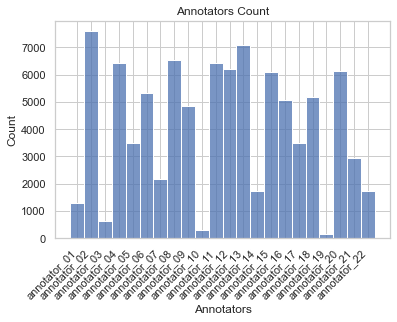

In [103]:
bike.generate_annotators_graph_count()

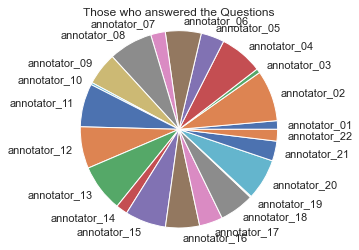

In [104]:
bike.generate_pie_for_answered_questions()
        

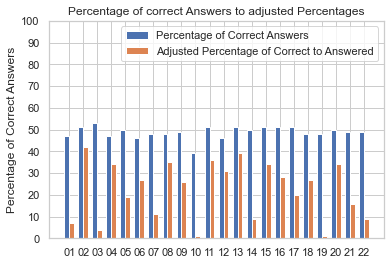

In [105]:
bike.generate_adjusted_graph()
        

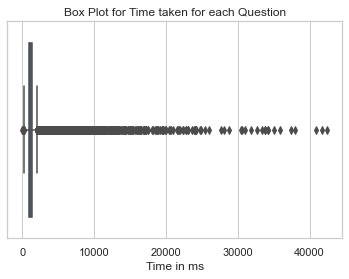

In [107]:
bike.generate_duration_overal()
        

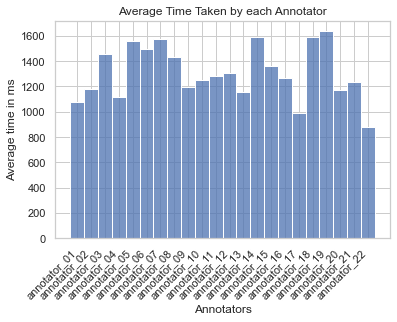

In [108]:
bike.generate_average_time()
        